In [67]:
import pandas as pd
import numpy as np
import re
import spacy
import nltk

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models  
import matplotlib.pyplot as plt

In [68]:
data1 = pd.read_csv('climate_data_sentiment_headlines.csv',encoding='latin1')
data2 = pd.read_csv('final_data.csv',encoding='latin1')
df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)

right_on = ['id', 'date_publish', 'outlet', 'headline', 'lead', 'body', 'authors', 'domain', 'url', 'political_leaning']
#left_on = ['id', 'date_publish', 'outlet', 'headline', 'lead', 'body', 'authors', 'domain', 'url', 'political_leaning']
#df = pd.merge(df1 ,df2, on=['id', 'date_publish', 'outlet', 'headline', 'lead', 'body', 'authors', 'domain', 'url', 'political_leaning'], how='left')
df = pd.merge(df1 ,df2, on=['id', 'date_publish', 'outlet', 'authors', 'domain', 'url', 'political_leaning'], how='inner')
df = df.drop(labels=['headline_y', 'lead_y', 'body_y', 'Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 'Unnamed: 0.1.1.1.1'], axis=1)
df = df.rename(columns={"headline_x": "headline", "lead_x": "lead", "body_x": "body"})
df

,id,date_publish,outlet,headline,lead,body,authors,domain,url,political_leaning,...,vader_polarity_negative,vader_polarity_neutral,vader_polarity_positive,vader_polarity_compound,gwsd_pred,vader_polarity_pred,textblob_polarity_pred,textblob_subjectivity_pred,firstp,scores
0,39113103,2017-01-01 00:05:41,The Guardian,The moderate insurgency: A better world can em...,A backlash to a year of extremes and polarisat...,"After the events of 2016, foreseeing the year ...",Matthew Taylor,www.theguardian.com,https://www.theguardian.com/commentisfree/2017...,LEFT,...,0.178,0.651,0.172,-0.0258,1,1,2,1,a backlash to a year of extremes and polarisat...,"{'climate impact': 0.5624255537986755, 'climat..."
1,38945556,2017-01-01 07:00:49,The Guardian,"Brexit, Trump, and bad news for Labour: our re...","As the new year dawns, share your hopes and fe...",What kind of year will 2017 be? In terms of po...,James Walsh;Guardian Readers,www.theguardian.com,https://www.theguardian.com/news/2017/jan/01/b...,LEFT,...,0.259,0.741,0.000,-0.5423,1,0,0,1,as the new year dawns share your hopes and fe...,"{'climate impact': 0.33482301235198975, 'clima..."
2,4282690,2017-01-01 08:25:51,Breitbart,Rules for Righties -- a War-Winning Manifesto ...,2016 was a great year for most of us - but jus...,\n2016 was a great year for most of us ÃÂ¢ÃÂ...,James Delingpole,www.breitbart.com,http://www.breitbart.com/london/2017/01/01/201...,RIGHT,...,0.000,1.000,0.000,0.0000,1,1,1,0,2016 was a great year for most of us but jus...,"{'climate impact': 0.49600180983543396, 'clima..."
3,39038266,2017-01-01 17:00:01,The Guardian,The BBCÃÂ¢ÃÂÃÂs Planet Earth II did not h...,Producers claim such series encourage conserva...,It has been wonderful watching Planet Earth II...,Martin Hughes-Games,www.theguardian.com,https://www.theguardian.com/commentisfree/2017...,LEFT,...,0.327,0.673,0.000,-0.5216,0,0,2,0,producers claim such series encourage conserva...,"{'climate impact': 0.7899065017700195, 'climat..."
4,3933475,2017-01-01 23:05:38,HuffPost,"Climate Change This Week: Vanishing Life, Sola...","Today, the Earth got a little hotter, and a li...","Today, the Earth got a little hotter, and a li...",Mary Ellen Harte;Biologist,www.huffingtonpost.com,http://www.huffingtonpost.com/mary-ellen-harte...,LEFT,...,0.000,1.000,0.000,0.0000,0,1,2,0,today the earth got a little hotter and a li...,"{'climate change': 0.9899488091468811, 'climat..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12144,3876703,2019-08-30 18:59:25,HuffPost,Hundreds Of Young People Strike In Front Of UN...,Teen climate activist Greta Thunberg joined th...,NEW YORK ÃÂ¢ÃÂÃÂ Hundreds of young people...,Senior Reporter,www.huffpost.com,https://www.huffpost.com/entry/united-nations-...,LEFT,...,0.120,0.880,0.000,-0.1280,1,0,2,0,teen climate activist greta thunberg joined th...,"{'climate change': 0.9895257353782654, 'climat..."
12145,4342931,2019-08-30 22:17:30,Breitbart,Alexandria Ocasio-Cortez Unveils Green New Dea...,Rep. Alexandria Ocasio-Cortez (D-NY) released ...,Rep. Alexandria Ocasio-Cortez (D-NY) released ...,Kyle Morris,www.breitbart.com,https://www.breitbart.com/politics/2019/08/30/...,RIGHT,...,0.000,1.000,0.000,0.0000,1,1,1,0,rep alexandria ocasio cortez d ny released ...,"{'climate impact': 0.8118867874145508, 'climat..."
12146,4309962,2019-08-31 06:05:23,Breitbart,Climate Change Will Produce ÃÂ¢ÃÂÃÂPowerf...,The U.N. High Commissioner on Human Rights war...,"The U.N. High Commissioner on Human Rights, Mi...",Thomas D. Williams,www.breitbart.com,https://www.breitbart.com/environment/2019/08/...,RIGHT,...,0.000,1.000,0.000,0.0000,1,1,1,0,the u n high commissioner on human rights war...,"{'climate change': 0.99802166223526, 'climate ..."
12147,4331363,2019-08-31 19:05:37,Breitbart,China Claims Trade War Hinders Efforts to Cont...,Communist China claims its trade war with the ...,The Chinese Ministry of Ecology and Environmen...,John Hayward,www.breitbart.com

#names = ['id', 'date_publish', 'outlet', 'headline', 'lead', 'body', 'authors', 'domain', 'url', 'political_leaning', 'processed_body', 'textblob_polarity', 'textblob_subjectivity', 'vader_polarity']
data = pd.read_csv('climate_data_sentiment_titles.csv',encoding='latin1')
df = pd.DataFrame(data)
# Make sure the following columns are all strings
df['body'] = df['body'].astype(str)
df['lead'] = df['lead'].astype(str)
df['headline'] = df['headline'].astype(str)
#df['processed_body'] = df['processed_body'].astype(str)
df.head()

In [69]:
# Before setting up the LDA, let's remove the invalid entries from the dataframe 
# This way it won't interfere with the vocabulary we build
df = df[df['outlet'] != 'BBC']
df = df[df['outlet'] != 'The Wall Street Journal'] 
df

,id,date_publish,outlet,headline,lead,body,authors,domain,url,political_leaning,...,vader_polarity_negative,vader_polarity_neutral,vader_polarity_positive,vader_polarity_compound,gwsd_pred,vader_polarity_pred,textblob_polarity_pred,textblob_subjectivity_pred,firstp,scores
0,39113103,2017-01-01 00:05:41,The Guardian,The moderate insurgency: A better world can em...,A backlash to a year of extremes and polarisat...,"After the events of 2016, foreseeing the year ...",Matthew Taylor,www.theguardian.com,https://www.theguardian.com/commentisfree/2017...,LEFT,...,0.178,0.651,0.172,-0.0258,1,1,2,1,a backlash to a year of extremes and polarisat...,"{'climate impact': 0.5624255537986755, 'climat..."
1,38945556,2017-01-01 07:00:49,The Guardian,"Brexit, Trump, and bad news for Labour: our re...","As the new year dawns, share your hopes and fe...",What kind of year will 2017 be? In terms of po...,James Walsh;Guardian Readers,www.theguardian.com,https://www.theguardian.com/news/2017/jan/01/b...,LEFT,...,0.259,0.741,0.000,-0.5423,1,0,0,1,as the new year dawns share your hopes and fe...,"{'climate impact': 0.33482301235198975, 'clima..."
2,4282690,2017-01-01 08:25:51,Breitbart,Rules for Righties -- a War-Winning Manifesto ...,2016 was a great year for most of us - but jus...,\n2016 was a great year for most of us ÃÂ¢ÃÂ...,James Delingpole,www.breitbart.com,http://www.breitbart.com/london/2017/01/01/201...,RIGHT,...,0.000,1.000,0.000,0.0000,1,1,1,0,2016 was a great year for most of us but jus...,"{'climate impact': 0.49600180983543396, 'clima..."
3,39038266,2017-01-01 17:00:01,The Guardian,The BBCÃÂ¢ÃÂÃÂs Planet Earth II did not h...,Producers claim such series encourage conserva...,It has been wonderful watching Planet Earth II...,Martin Hughes-Games,www.theguardian.com,https://www.theguardian.com/commentisfree/2017...,LEFT,...,0.327,0.673,0.000,-0.5216,0,0,2,0,producers claim such series encourage conserva...,"{'climate impact': 0.7899065017700195, 'climat..."
4,3933475,2017-01-01 23:05:38,HuffPost,"Climate Change This Week: Vanishing Life, Sola...","Today, the Earth got a little hotter, and a li...","Today, the Earth got a little hotter, and a li...",Mary Ellen Harte;Biologist,www.huffingtonpost.com,http://www.huffingtonpost.com/mary-ellen-harte...,LEFT,...,0.000,1.000,0.000,0.0000,0,1,2,0,today the earth got a little hotter and a li...,"{'climate change': 0.9899488091468811, 'climat..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12144,3876703,2019-08-30 18:59:25,HuffPost,Hundreds Of Young People Strike In Front Of UN...,Teen climate activist Greta Thunberg joined th...,NEW YORK ÃÂ¢ÃÂÃÂ Hundreds of young people...,Senior Reporter,www.huffpost.com,https://www.huffpost.com/entry/united-nations-...,LEFT,...,0.120,0.880,0.000,-0.1280,1,0,2,0,teen climate activist greta thunberg joined th...,"{'climate change': 0.9895257353782654, 'climat..."
12145,4342931,2019-08-30 22:17:30,Breitbart,Alexandria Ocasio-Cortez Unveils Green New Dea...,Rep. Alexandria Ocasio-Cortez (D-NY) released ...,Rep. Alexandria Ocasio-Cortez (D-NY) released ...,Kyle Morris,www.breitbart.com,https://www.breitbart.com/politics/2019/08/30/...,RIGHT,...,0.000,1.000,0.000,0.0000,1,1,1,0,rep alexandria ocasio cortez d ny released ...,"{'climate impact': 0.8118867874145508, 'climat..."
12146,4309962,2019-08-31 06:05:23,Breitbart,Climate Change Will Produce ÃÂ¢ÃÂÃÂPowerf...,The U.N. High Commissioner on Human Rights war...,"The U.N. High Commissioner on Human Rights, Mi...",Thomas D. Williams,www.breitbart.com,https://www.breitbart.com/environment/2019/08/...,RIGHT,...,0.000,1.000,0.000,0.0000,1,1,1,0,the u n high commissioner on human rights war...,"{'climate change': 0.99802166223526, 'climate ..."
12147,4331363,2019-08-31 19:05:37,Breitbart,China Claims Trade War Hinders Efforts to Cont...,Communist China claims its trade war with the ...,The Chinese Ministry of Ecology and Environmen...,John Hayward,www.breitbart.com

In [17]:
print(len(df))
print(len(df[df['body'].str.split().str.len().gt(100)]) ) 
print(df[df['body'].str.split().str.len().lt(100)]) 

11308
11073
              id         date_publish    outlet  \
28      52908024  2017-01-05 00:00:00       NPR   
159     52868499  2017-01-18 00:00:00       NPR   
161     52928699  2017-01-18 00:00:00       NPR   
380      1165007  2017-02-01 16:07:31   Reuters   
467     52871819  2017-02-15 00:00:00       NPR   
...          ...                  ...       ...   
12029  113883720  2019-08-26 13:00:44  CBS News   
12030  113832172  2019-08-26 13:00:44  CBS News   
12038   52868617  2019-08-27 00:00:00       NPR   
12069   55233370  2019-08-28 12:03:00  NBC News   
12087   52890098  2019-08-29 00:00:00       NPR   

                                                headline  \
28     Climate Scientist Pens Open Letter To Presiden...   
159    U.S. Report Confirms 2016 Was The Hottest Year...   
161    EPA Nominee Scott Pruitt Acknowledges Existenc...   
380    Senate Democrats boycott vote on Trump's pick ...   
467    The Trump Presidency's Potential Impact On Cli...   
...            

In [19]:
# The following few cells are inspired by the article https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# Get rid of the .head(1000) to work on the entire dataframe or add it: df['processed_body']).head(1000)     
data_words = list(sent_to_words(df['processed_body']))

print(data_words[:1])

[['events', 'foreseeing', 'year', 'ahead', 'may', 'foolhardy', 'best', 'perhaps', 'abandon', 'task', 'objective', 'prediction', 'favour', 'search', 'hope', 'chance', 'accept', 'complexity', 'rather', 'demand', 'false', 'certainty', 'search', 'solutions', 'blame', 'could', 'act', 'together', 'could', 'year', 'moderate', 'insurgency', 'insurgency', 'needs', 'help', 'enemies', 'expect', 'betrayal', 'many', 'lips', 'year', 'unfolds', 'complexity', 'cost', 'brexit', 'becomes', 'clearer', 'rest', 'europe', 'demanding', 'high', 'price', 'access', 'single', 'market', 'many', 'voted', 'high', 'hopes', 'dismayed', 'leave', 'side', 'acrimonious', 'split', 'grow', 'realists', 'willing', 'negotiate', 'terms', 'qualified', 'departure', 'fundamentalists', 'see', 'complete', 'rupture', 'european', 'mainstream', 'path', 'national', 'resurgence', 'us', 'donald', 'trump', 'radical', 'supporters', 'already', 'protesting', 'abandonment', 'wacky', 'campaign', 'promises', 'trump', 'presidency', 'vividly', 'd

In [20]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['events', 'foreseeing', 'year', 'ahead', 'may', 'foolhardy', 'best', 'perhaps', 'abandon', 'task', 'objective', 'prediction', 'favour', 'search', 'hope', 'chance', 'accept', 'complexity', 'rather', 'demand', 'false', 'certainty', 'search', 'solutions', 'blame', 'could', 'act', 'together', 'could', 'year', 'moderate', 'insurgency', 'insurgency', 'needs', 'help', 'enemies', 'expect', 'betrayal', 'many', 'lips', 'year', 'unfolds', 'complexity', 'cost', 'brexit', 'becomes', 'clearer', 'rest', 'europe', 'demanding', 'high', 'price', 'access', 'single', 'market', 'many', 'voted', 'high', 'hopes', 'dismayed', 'leave', 'side', 'acrimonious', 'split', 'grow', 'realists', 'willing', 'negotiate', 'terms', 'qualified', 'departure', 'fundamentalists', 'see', 'complete', 'rupture', 'european', 'mainstream', 'path', 'national', 'resurgence', 'us', 'donald', 'trump', 'radical', 'supporters', 'already', 'protesting', 'abandonment', 'wacky', 'campaign', 'promises', 'trump', 'presidency', 'vividly', 'de

In [21]:
# Define functions for bigrams, trigrams and lemmatization
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [22]:
# This takes a long time (10ish minutes for the full dataset) so beware

# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['event', 'foresee', 'year', 'ahead', 'foolhardy', 'well', 'perhaps', 'abandon', 'task', 'objective', 'prediction', 'favour', 'search', 'hope', 'chance', 'accept', 'complexity', 'rather', 'demand', 'false', 'certainty', 'search', 'solution', 'blame', 'act', 'together', 'year', 'moderate', 'insurgency', 'insurgency', 'need', 'help', 'enemy', 'expect', 'betrayal', 'many', 'lip', 'year', 'unfold', 'complexity', 'cost', 'brexit', 'become', 'clear', 'demand', 'high', 'price', 'access', 'single', 'market', 'many', 'vote', 'high', 'hope', 'dismay', 'leave', 'side', 'acrimonious', 'split', 'grow', 'realist', 'willing', 'negotiate', 'term', 'qualified', 'departure', 'fundamentalist', 'see', 'complete', 'european', 'national', 'resurgence', 'radical', 'supporter', 'already', 'protest', 'abandonment', 'wacky', 'campaign', 'promise', 'vividly', 'demonstrate', 'gap', 'populism', 'strength', 'campaign', 'tool', 'inadequacy', 'method', 'new', 'erratic', 'behaviour', 'incoherent', 'policy', 'programm

In [23]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Create a small subset of all these so that the code runs in reasonable time
data_lemmatized_short = data_lemmatized[:1000]
id2word_short = corpora.Dictionary(data_lemmatized[:1000])
texts = data_lemmatized[:1000]
corpus_short = [id2word_short.doc2bow(text) for text in texts]


[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 3), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 2), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 1), (27, 2), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 2), (38, 4), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 2), (48, 1), (49, 2), (50, 1), (51, 1), (52, 3), (53, 1), (54, 1), (55, 1), (56, 1), (57, 2), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 3), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 2), (78, 1), (79, 2), (80, 1), (81, 2), (82, 1), (83, 1), (84, 1), (85, 2), (86, 2), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 2), (94, 2), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 2), (108, 1), (109, 1), (110, 2)

In [24]:
#f = open("corpus.txt", "a")
#f.write(str(corpus))
#f.close()
#id2word

In [25]:
# Build LDA model

def create_lda(num_topics):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=num_topics, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)
    
    return lda_model


In [ ]:
lda_model = create_lda(5)
lda_model.print_topics()

In [ ]:
lda_model = create_lda(8)
lda_model.print_topics()

In [28]:
lda_model = create_lda(10)
lda_model.print_topics()


[(0,
  '0.029*"government" + 0.015*"say" + 0.014*"policy" + 0.014*"company" + 0.012*"australia" + 0.011*"fund" + 0.009*"labor" + 0.008*"australian" + 0.008*"support" + 0.007*"target"'),
 (1,
  '0.120*"climate" + 0.060*"change" + 0.041*"say" + 0.017*"action" + 0.015*"global" + 0.014*"country" + 0.014*"world" + 0.013*"emission" + 0.011*"crisis" + 0.009*"take"'),
 (2,
  '0.026*"state" + 0.019*"administration" + 0.019*"rule" + 0.018*"environmental" + 0.015*"federal" + 0.015*"agency" + 0.015*"say" + 0.012*"plan" + 0.011*"regulation" + 0.011*"oil"'),
 (3,
  '0.049*"climate" + 0.030*"change" + 0.019*"global" + 0.019*"scientist" + 0.018*"report" + 0.015*"study" + 0.015*"temperature" + 0.014*"science" + 0.014*"year" + 0.012*"warming"'),
 (4,
  '0.082*"protest" + 0.046*"protester" + 0.041*"extinction_rebellion" + 0.035*"pipeline" + 0.034*"activist" + 0.029*"arrest" + 0.022*"group" + 0.013*"oil" + 0.013*"site" + 0.012*"project"'),
 (5,
  '0.023*"say" + 0.015*"candidate" + 0.014*"deal" + 0.013*"ca

In [126]:
lda_model = create_lda(8)
lda_model.print_topics()

[(0,
  '0.027*"emission" + 0.020*"energy" + 0.018*"carbon" + 0.017*"climate" + 0.013*"government" + 0.012*"coal" + 0.012*"say" + 0.011*"new" + 0.010*"power" + 0.009*"year"'),
 (1,
  '0.033*"state" + 0.023*"protest" + 0.020*"group" + 0.019*"activist" + 0.019*"oil" + 0.015*"bill" + 0.013*"emergency" + 0.013*"protester" + 0.012*"environmental" + 0.011*"law"'),
 (2,
  '0.012*"use" + 0.010*"car" + 0.009*"gas" + 0.009*"company" + 0.009*"year" + 0.008*"new" + 0.007*"make" + 0.007*"city" + 0.007*"fuel" + 0.006*"state"'),
 (3,
  '0.062*"climate" + 0.035*"change" + 0.024*"global" + 0.018*"scientist" + 0.015*"warming" + 0.014*"year" + 0.014*"study" + 0.013*"temperature" + 0.013*"science" + 0.013*"report"'),
 (4,
  '0.023*"people" + 0.013*"change" + 0.011*"climate" + 0.010*"world" + 0.009*"take" + 0.008*"make" + 0.008*"time" + 0.007*"crisis" + 0.007*"need" + 0.007*"work"'),
 (5,
  '0.046*"say" + 0.042*"climate" + 0.026*"change" + 0.014*"plan" + 0.009*"administration" + 0.008*"issue" + 0.008*"call"

In [18]:
lda_model = create_lda(11)
lda_model.print_topics()

[(0,
  '0.027*"state" + 0.015*"say" + 0.014*"federal" + 0.014*"plan" + 0.012*"administration" + 0.011*"rule" + 0.011*"bill" + 0.010*"law" + 0.008*"agency" + 0.008*"group"'),
 (1,
  '0.023*"say" + 0.015*"city" + 0.015*"water" + 0.013*"year" + 0.012*"fire" + 0.009*"land" + 0.008*"area" + 0.008*"state" + 0.008*"food" + 0.007*"people"'),
 (2,
  '0.026*"people" + 0.011*"school" + 0.009*"child" + 0.009*"student" + 0.008*"world" + 0.008*"crisis" + 0.008*"take" + 0.007*"young" + 0.007*"government" + 0.007*"change"'),
 (3,
  '0.030*"say" + 0.016*"trump" + 0.013*"president" + 0.011*"day" + 0.010*"week" + 0.008*"tell" + 0.008*"report" + 0.008*"former" + 0.007*"time" + 0.007*"call"'),
 (4,
  '0.065*"health" + 0.028*"woman" + 0.023*"child" + 0.020*"patient" + 0.019*"medical" + 0.018*"death" + 0.018*"abortion" + 0.018*"hospital" + 0.018*"drug" + 0.017*"girl"'),
 (5,
  '0.050*"s" + 0.032*"go" + 0.024*"people" + 0.019*"re" + 0.017*"thing" + 0.015*"ve" + 0.015*"make" + 0.014*"get" + 0.014*"really" + 0.

In [19]:
lda_model = create_lda(12)
lda_model.print_topics()

[(0,
  '0.028*"state" + 0.016*"federal" + 0.013*"bill" + 0.012*"rule" + 0.012*"plan" + 0.012*"administration" + 0.011*"law" + 0.009*"agency" + 0.009*"public" + 0.008*"program"'),
 (1,
  '0.026*"say" + 0.014*"city" + 0.014*"year" + 0.013*"water" + 0.011*"fire" + 0.009*"state" + 0.008*"use" + 0.008*"land" + 0.007*"area" + 0.007*"home"'),
 (2,
  '0.021*"people" + 0.010*"school" + 0.009*"child" + 0.008*"take" + 0.008*"year" + 0.008*"woman" + 0.007*"student" + 0.007*"day" + 0.007*"protest" + 0.006*"young"'),
 (3,
  '0.043*"say" + 0.021*"trump" + 0.017*"president" + 0.010*"former" + 0.010*"week" + 0.008*"climate" + 0.008*"call" + 0.008*"day" + 0.008*"report" + 0.008*"tell"'),
 (4,
  '0.080*"food" + 0.066*"health" + 0.043*"animal" + 0.022*"eat" + 0.021*"patient" + 0.017*"medical" + 0.016*"disease" + 0.016*"pound" + 0.015*"hospital" + 0.014*"rent"'),
 (5,
  '0.048*"s" + 0.031*"go" + 0.023*"people" + 0.019*"re" + 0.017*"thing" + 0.015*"make" + 0.014*"ve" + 0.014*"get" + 0.013*"really" + 0.013*"

In [20]:
lda_model = create_lda(13)
lda_model.print_topics()

[(0,
  '0.029*"trump" + 0.023*"president" + 0.012*"day" + 0.011*"week" + 0.008*"biden" + 0.008*"former" + 0.008*"time" + 0.008*"first" + 0.007*"last" + 0.007*"new"'),
 (1,
  '0.029*"say" + 0.020*"city" + 0.020*"water" + 0.017*"fire" + 0.015*"state" + 0.015*"year" + 0.010*"area" + 0.010*"land" + 0.009*"home" + 0.008*"amazon"'),
 (2,
  '0.012*"political" + 0.009*"people" + 0.009*"even" + 0.007*"many" + 0.006*"make" + 0.005*"power" + 0.005*"way" + 0.005*"time" + 0.005*"world" + 0.005*"become"'),
 (3,
  '0.027*"candidate" + 0.023*"democratic" + 0.020*"say" + 0.019*"campaign" + 0.019*"debate" + 0.017*"state" + 0.014*"voter" + 0.014*"vote" + 0.012*"party" + 0.011*"election"'),
 (4,
  '0.127*"health" + 0.052*"patient" + 0.034*"medical" + 0.031*"exposure" + 0.027*"disease" + 0.025*"cancer" + 0.024*"tick" + 0.022*"doctor" + 0.016*"radiation" + 0.016*"death"'),
 (5,
  '0.041*"s" + 0.028*"go" + 0.023*"people" + 0.019*"say" + 0.016*"re" + 0.015*"thing" + 0.015*"make" + 0.013*"get" + 0.012*"ve" + 0

In [21]:
lda_model = create_lda(14)
lda_model.print_topics()

[(0,
  '0.032*"state" + 0.018*"plan" + 0.017*"federal" + 0.013*"bill" + 0.012*"new" + 0.012*"rule" + 0.012*"administration" + 0.011*"say" + 0.011*"law" + 0.009*"policy"'),
 (1,
  '0.037*"say" + 0.026*"water" + 0.021*"fire" + 0.015*"land" + 0.013*"food" + 0.012*"farmer" + 0.010*"amazon" + 0.010*"area" + 0.009*"forest" + 0.009*"year"'),
 (2,
  '0.021*"s" + 0.019*"people" + 0.015*"go" + 0.012*"make" + 0.011*"way" + 0.010*"thing" + 0.009*"time" + 0.009*"well" + 0.009*"re" + 0.009*"see"'),
 (3,
  '0.051*"say" + 0.022*"trump" + 0.020*"president" + 0.012*"week" + 0.010*"former" + 0.009*"make" + 0.009*"tell" + 0.009*"call" + 0.009*"day" + 0.009*"climate"'),
 (4,
  '0.143*"health" + 0.050*"patient" + 0.032*"medical" + 0.031*"disease" + 0.031*"exposure" + 0.030*"cancer" + 0.025*"drug" + 0.023*"tick" + 0.021*"doctor" + 0.016*"death"'),
 (5,
  '0.000*"chestthumpe" + 0.000*"danko" + 0.000*"demonstrators_chante" + 0.000*"expressionless" + 0.000*"latest_salvo" + 0.000*"chapstick" + 0.000*"perperson" 

In [22]:
lda_model = create_lda(15)
lda_model.print_topics()

[(0,
  '0.021*"rule" + 0.020*"administration" + 0.018*"federal" + 0.016*"agency" + 0.014*"state" + 0.014*"law" + 0.012*"court" + 0.011*"regulation" + 0.011*"official" + 0.011*"government"'),
 (1,
  '0.033*"say" + 0.019*"water" + 0.016*"fire" + 0.011*"year" + 0.011*"land" + 0.011*"city" + 0.010*"food" + 0.009*"area" + 0.009*"farmer" + 0.007*"people"'),
 (2,
  '0.036*"s" + 0.026*"people" + 0.025*"go" + 0.015*"make" + 0.015*"thing" + 0.014*"re" + 0.012*"see" + 0.012*"well" + 0.012*"way" + 0.012*"come"'),
 (3,
  '0.047*"say" + 0.021*"trump" + 0.018*"president" + 0.012*"former" + 0.011*"week" + 0.009*"campaign" + 0.009*"day" + 0.008*"report" + 0.008*"tell" + 0.008*"call"'),
 (4,
  '0.144*"health" + 0.058*"patient" + 0.041*"hospital" + 0.038*"medical" + 0.034*"drug" + 0.030*"disease" + 0.030*"cancer" + 0.024*"doctor" + 0.018*"death" + 0.017*"medicine"'),
 (5,
  '0.049*"government" + 0.015*"australia" + 0.015*"need" + 0.015*"brexit" + 0.012*"emergency" + 0.011*"read" + 0.011*"change" + 0.010*

In [117]:
lda_model = create_lda(9)
lda_model.print_topics()

[(0,
  '0.026*"emission" + 0.018*"carbon" + 0.018*"energy" + 0.013*"government" + 0.012*"say" + 0.012*"new" + 0.010*"year" + 0.009*"power" + 0.009*"company" + 0.008*"coal"'),
 (1,
  '0.033*"gas" + 0.027*"oil" + 0.018*"industry" + 0.018*"rule" + 0.017*"administration" + 0.016*"emission" + 0.015*"company" + 0.015*"car" + 0.014*"state" + 0.014*"coal"'),
 (2,
  '0.016*"state" + 0.016*"city" + 0.014*"use" + 0.013*"land" + 0.013*"amazon" + 0.010*"food" + 0.009*"farmer" + 0.009*"environmental" + 0.007*"project" + 0.007*"also"'),
 (3,
  '0.032*"climate" + 0.022*"scientist" + 0.019*"study" + 0.018*"science" + 0.018*"change" + 0.017*"global" + 0.016*"year" + 0.016*"temperature" + 0.015*"warming" + 0.013*"report"'),
 (4,
  '0.024*"say" + 0.023*"fire" + 0.019*"water" + 0.016*"year" + 0.011*"tree" + 0.010*"area" + 0.009*"forest" + 0.007*"region" + 0.007*"home" + 0.006*"burn"'),
 (5,
  '0.046*"say" + 0.037*"climate" + 0.022*"change" + 0.015*"deal" + 0.013*"plan" + 0.012*"new" + 0.010*"call" + 0.009*

In [69]:
lda_model.save('lda.model')

In [123]:
# Get most likely topics for each document
all_topics = lda_model.get_document_topics(corpus, minimum_probability=0.0)
all_topics_csr = gensim.matutils.corpus2csc(all_topics)
all_topics_numpy = all_topics_csr.T.toarray()
all_topics_df = pd.DataFrame(all_topics_numpy.argmax(axis=1))

In [124]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/home/pjanul/miniconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/home/pjanul/miniconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/pjanul/miniconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/pjanul/miniconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/pjanul/miniconda3/lib/python3.9/site-packages/pa

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.027842 -0.094630       1        1  17.062273
5     -0.064209  0.025686       2        1  16.627771
7     -0.007002  0.220688       3        1  16.068097
4      0.077140  0.197810       4        1  15.426373
6      0.115362 -0.089398       5        1  12.045289
2      0.032912 -0.158450       6        1  10.013451
3      0.179529 -0.056692       7        1   9.875888
1     -0.361573 -0.045014       8        1   2.880858, topic_info=            Term          Freq         Total Category  logprob  loglift
49       climate  73611.000000  73611.000000  Default  30.0000  30.0000
998          say  52741.000000  52741.000000  Default  29.0000  29.0000
46        change  47464.000000  47464.000000  Default  28.0000  28.0000
1039       state  13503.000000  13503.000000  Default  27.0000  27.0000
1437    emission  21171.000000  21171.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
49       climate   1097.573767  73611.645683   Topic8  -4.6157  -0.6586
258       public    758.871702   6606.473357   Topic8  -4.9847   1.3831
144   government    773.464711  14092.334337   Topic8  -4.9657   0.6446
1048     support    702.602828   7762.432205   Topic8  -5.0618   1.1448
998          say    792.139823  52741.040195   Topic8  -4.9418  -0.6513

[596 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
362       3  0.998971  abortion
1915      1  0.088774    accord
1915      2  0.368878    accord
1915      5  0.151350    accord
1915      6  0.129623    accord
...     ...       ...       ...
360       6  0.123946      year
360       7  0.199132      year
360       8  0.008114      year
361       4  0.894633     young
361       8  0.105153     young

[1219 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 8, 5, 7, 3, 4, 2])

In [125]:
df.to_csv('climate_data_LDA_titles_filtered.csv', index=False)

In [116]:
all_topics_df

,0
0,7
1,7
2,7
3,4
4,6
...,...
11303,4
11304,7
11305,5
11306,0


data = pd.read_csv('climate_data_LDA_titles_filtered.csv',encoding='latin1')
df = pd.DataFrame(data)
# Make sure the following columns are all strings
df['body'] = df['body'].astype(str)
df['lead'] = df['lead'].astype(str)
df['headline'] = df['headline'].astype(str)
df['processed_body'] = df['processed_body'].astype(str)


# Before setting up the LDA, let's remove the invalid entries from the dataframe 
# This way it won't interfere with the vocabulary we build
df = df[df['outlet'] != 'BBC']
df = df[df['outlet'] != 'The Wall Street Journal'] 

df = df.reset_index(drop=True)
df['topic'] = all_topics_df
df['topic'] = df['topic'].astype(str)

df.to_csv("climate_data_LDA_titles_filtered.csv", index=False)

In [114]:
#df = pd.concat([df, all_topics_df], axis=1)
df = df.reset_index(drop=True)
df['topic'] = all_topics_df
df['topic'] = df['topic'].astype(str)
print(len(all_topics_df))
print(len(df))

df

11308
11308


,id,date_publish,outlet,headline,lead,body,authors,domain,url,political_leaning,...,vader_polarity_neutral,vader_polarity_positive,vader_polarity_compound,gwsd_pred,vader_polarity_pred,textblob_polarity_pred,textblob_subjectivity_pred,firstp,scores,topic
0,39113103,2017-01-01 00:05:41,The Guardian,The moderate insurgency: A better world can em...,A backlash to a year of extremes and polarisat...,"After the events of 2016, foreseeing the year ...",Matthew Taylor,www.theguardian.com,https://www.theguardian.com/commentisfree/2017...,LEFT,...,0.651,0.172,-0.0258,1,1,2,1,a backlash to a year of extremes and polarisat...,"{'climate impact': 0.5624255537986755, 'climat...",7
1,38945556,2017-01-01 07:00:49,The Guardian,"Brexit, Trump, and bad news for Labour: our re...","As the new year dawns, share your hopes and fe...",What kind of year will 2017 be? In terms of po...,James Walsh;Guardian Readers,www.theguardian.com,https://www.theguardian.com/news/2017/jan/01/b...,LEFT,...,0.741,0.000,-0.5423,1,0,0,1,as the new year dawns share your hopes and fe...,"{'climate impact': 0.33482301235198975, 'clima...",7
2,4282690,2017-01-01 08:25:51,Breitbart,Rules for Righties -- a War-Winning Manifesto ...,2016 was a great year for most of us - but jus...,\n2016 was a great year for most of us ÃÂ¢ÃÂ...,James Delingpole,www.breitbart.com,http://www.breitbart.com/london/2017/01/01/201...,RIGHT,...,1.000,0.000,0.0000,1,1,1,0,2016 was a great year for most of us but jus...,"{'climate impact': 0.49600180983543396, 'clima...",7
3,39038266,2017-01-01 17:00:01,The Guardian,The BBCÃÂ¢ÃÂÃÂs Planet Earth II did not h...,Producers claim such series encourage conserva...,It has been wonderful watching Planet Earth II...,Martin Hughes-Games,www.theguardian.com,https://www.theguardian.com/commentisfree/2017...,LEFT,...,0.673,0.000,-0.5216,0,0,2,0,producers claim such series encourage conserva...,"{'climate impact': 0.7899065017700195, 'climat...",4
4,3933475,2017-01-01 23:05:38,HuffPost,"Climate Change This Week: Vanishing Life, Sola...","Today, the Earth got a little hotter, and a li...","Today, the Earth got a little hotter, and a li...",Mary Ellen Harte;Biologist,www.huffingtonpost.com,http://www.huffingtonpost.com/mary-ellen-harte...,LEFT,...,1.000,0.000,0.0000,0,1,2,0,today the earth got a little hotter and a li...,"{'climate change': 0.9899488091468811, 'climat...",6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11303,3876703,2019-08-30 18:59:25,HuffPost,Hundreds Of Young People Strike In Front Of UN...,Teen climate activist Greta Thunberg joined th...,NEW YORK ÃÂ¢ÃÂÃÂ Hundreds of young people...,Senior Reporter,www.huffpost.com,https://www.huffpost.com/entry/united-nations-...,LEFT,...,0.880,0.000,-0.1280,1,0,2,0,teen climate activist greta thunberg joined th...,"{'climate change': 0.9895257353782654, 'climat...",4
11304,4342931,2019-08-30 22:17:30,Breitbart,Alexandria Ocasio-Cortez Unveils Green New Dea...,Rep. Alexandria Ocasio-Cortez (D-NY) released ...,Rep. Alexandria Ocasio-Cortez (D-NY) released ...,Kyle Morris,www.breitbart.com,https://www.breitbart.com/politics/2019/08/30/...,RIGHT,...,1.000,0.000,0.0000,1,1,1,0,rep alexandria ocasio cortez d ny released ...,"{'climate impact': 0.8118867874145508, 'climat...",7
11305,4309962,2019-08-31 06:05:23,Breitbart,Climate Change Will Produce ÃÂ¢ÃÂÃÂPowerf...,The U.N. High Commissioner on Human Rights war...,"The U.N. High Commissioner on Human Rights, Mi...",Thomas D. Williams,www.breitbart.com,https://www.breitbart.com/environment/2019/08/...,RIGHT,...,1.000,0.000,0.0000,1,1,1,0,the u n high commissioner on human rights war...,"{'climate change': 0.99802166223526, 'climate ...",5
11306,4331363,2019-08-31 19:05:37,Breitbart,China Claims Trade War Hinders Efforts to Cont...,Communist China claims its trade war with the ...,The Chinese Ministry of Ecology and Environmen...,John Hayward,www.breitbart.com,https://www.breitbart.com/national-security/20...

In [115]:

def infer_opinion(df):
    
    tb_neg_df = df[df['textblob_polarity'] < 0]
    tb_pos_df = df[df['textblob_polarity'] > 0]
    tb_obj_df = df[df['textblob_subjectivity'] < 0.5]
    tb_subj_df = df[df['textblob_subjectivity'] > 0.5]
    vs_neg_df = df[df['vader_polarity_compound'] < 0]
    vs_pos_df = df[df['vader_polarity_compound'] > 0]
    
    gwsd_neg_df = df[df['gwsd_pred'] == 0]
    gwsd_neu_df = df[df['gwsd_pred'] == 1]
    gwsd_pos_df = df[df['gwsd_pred'] == 2]

    print("Number of negative articles from textblob: ", len(tb_neg_df))
    print("Number of positive articles from textblob: ", len(tb_pos_df))
    print("Number of objective articles from textblob: ", len(tb_obj_df))
    print("Number of subjective articles from textblob: ", len(tb_subj_df))
    print("Number of negative articles from VADER: ", len(vs_neg_df))
    print("Number of positive articles from VADER: ", len(vs_pos_df))


    # Get the count of each article, sorted alphabetically
    total_counts = df.political_leaning.value_counts().sort_index(ascending=True)
    neg_counts = tb_neg_df.outlet.value_counts().sort_index(ascending=True)
    pos_counts = tb_pos_df.outlet.value_counts().sort_index(ascending=True)
    obj_counts = tb_obj_df.outlet.value_counts().sort_index(ascending=True)
    subj_counts = tb_subj_df.outlet.value_counts().sort_index(ascending=True)
    vs_neg_counts = vs_neg_df.outlet.value_counts().sort_index(ascending=True)
    vs_pos_counts = vs_pos_df.outlet.value_counts().sort_index(ascending=True)
    
    gwsd_neg_counts = gwsd_neg_df.political_leaning.value_counts().sort_index(ascending=True)
    gwsd_pos_counts = gwsd_pos_df.political_leaning.value_counts().sort_index(ascending=True)
    gwsd_neu_counts = gwsd_neu_df.political_leaning.value_counts().sort_index(ascending=True)
    print('\n')

    print("Rates of negative articles:\n")
    print((neg_counts/total_counts).sort_values(ascending=False), '\n\n')

    print("Rates of positive articles:\n")
    print((pos_counts/total_counts).sort_values(ascending=False), '\n\n')

    print("Rates of objective articles:\n")
    print((obj_counts/total_counts).sort_values(ascending=False), '\n\n')

    print("Rates of subjective articles:\n")
    print((subj_counts/total_counts).sort_values(ascending=False), '\n\n')
    #print(neg_df.outlet.value_counts().sort_index(ascending=True)/df.outlet.value_counts().sort_index(ascending=True), '\n')

    print("Rates of negative articles using VADER:\n")
    print((vs_neg_counts/total_counts).sort_values(ascending=False), '\n\n')

    print("Rates of positive articles using VADER:\n")
    print((vs_pos_counts/total_counts).sort_values(ascending=False), '\n\n')
    
    print("Rates of positive articles using GWSD:\n")
    print((gwsd_pos_counts/total_counts).sort_values(ascending=False), '\n\n')
    
    print("Rates of neutral articles using GWSD:\n")
    print((gwsd_neu_counts/total_counts).sort_values(ascending=False), '\n\n')
    
    print("Rates of negative articles using GWSD:\n")
    print((gwsd_neg_counts/total_counts).sort_values(ascending=False), '\n\n')


In [112]:
len(df)

11308

In [113]:
df

,id,date_publish,outlet,headline,lead,body,authors,domain,url,political_leaning,...,vader_polarity_neutral,vader_polarity_positive,vader_polarity_compound,gwsd_pred,vader_polarity_pred,textblob_polarity_pred,textblob_subjectivity_pred,firstp,scores,topic
0,39113103,2017-01-01 00:05:41,The Guardian,The moderate insurgency: A better world can em...,A backlash to a year of extremes and polarisat...,"After the events of 2016, foreseeing the year ...",Matthew Taylor,www.theguardian.com,https://www.theguardian.com/commentisfree/2017...,LEFT,...,0.651,0.172,-0.0258,1,1,2,1,a backlash to a year of extremes and polarisat...,"{'climate impact': 0.5624255537986755, 'climat...",7
1,38945556,2017-01-01 07:00:49,The Guardian,"Brexit, Trump, and bad news for Labour: our re...","As the new year dawns, share your hopes and fe...",What kind of year will 2017 be? In terms of po...,James Walsh;Guardian Readers,www.theguardian.com,https://www.theguardian.com/news/2017/jan/01/b...,LEFT,...,0.741,0.000,-0.5423,1,0,0,1,as the new year dawns share your hopes and fe...,"{'climate impact': 0.33482301235198975, 'clima...",7
2,4282690,2017-01-01 08:25:51,Breitbart,Rules for Righties -- a War-Winning Manifesto ...,2016 was a great year for most of us - but jus...,\n2016 was a great year for most of us ÃÂ¢ÃÂ...,James Delingpole,www.breitbart.com,http://www.breitbart.com/london/2017/01/01/201...,RIGHT,...,1.000,0.000,0.0000,1,1,1,0,2016 was a great year for most of us but jus...,"{'climate impact': 0.49600180983543396, 'clima...",7
3,39038266,2017-01-01 17:00:01,The Guardian,The BBCÃÂ¢ÃÂÃÂs Planet Earth II did not h...,Producers claim such series encourage conserva...,It has been wonderful watching Planet Earth II...,Martin Hughes-Games,www.theguardian.com,https://www.theguardian.com/commentisfree/2017...,LEFT,...,0.673,0.000,-0.5216,0,0,2,0,producers claim such series encourage conserva...,"{'climate impact': 0.7899065017700195, 'climat...",4
4,3933475,2017-01-01 23:05:38,HuffPost,"Climate Change This Week: Vanishing Life, Sola...","Today, the Earth got a little hotter, and a li...","Today, the Earth got a little hotter, and a li...",Mary Ellen Harte;Biologist,www.huffingtonpost.com,http://www.huffingtonpost.com/mary-ellen-harte...,LEFT,...,1.000,0.000,0.0000,0,1,2,0,today the earth got a little hotter and a li...,"{'climate change': 0.9899488091468811, 'climat...",6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11303,3876703,2019-08-30 18:59:25,HuffPost,Hundreds Of Young People Strike In Front Of UN...,Teen climate activist Greta Thunberg joined th...,NEW YORK ÃÂ¢ÃÂÃÂ Hundreds of young people...,Senior Reporter,www.huffpost.com,https://www.huffpost.com/entry/united-nations-...,LEFT,...,0.880,0.000,-0.1280,1,0,2,0,teen climate activist greta thunberg joined th...,"{'climate change': 0.9895257353782654, 'climat...",4
11304,4342931,2019-08-30 22:17:30,Breitbart,Alexandria Ocasio-Cortez Unveils Green New Dea...,Rep. Alexandria Ocasio-Cortez (D-NY) released ...,Rep. Alexandria Ocasio-Cortez (D-NY) released ...,Kyle Morris,www.breitbart.com,https://www.breitbart.com/politics/2019/08/30/...,RIGHT,...,1.000,0.000,0.0000,1,1,1,0,rep alexandria ocasio cortez d ny released ...,"{'climate impact': 0.8118867874145508, 'climat...",7
11305,4309962,2019-08-31 06:05:23,Breitbart,Climate Change Will Produce ÃÂ¢ÃÂÃÂPowerf...,The U.N. High Commissioner on Human Rights war...,"The U.N. High Commissioner on Human Rights, Mi...",Thomas D. Williams,www.breitbart.com,https://www.breitbart.com/environment/2019/08/...,RIGHT,...,1.000,0.000,0.0000,1,1,1,0,the u n high commissioner on human rights war...,"{'climate change': 0.99802166223526, 'climate ...",5
11306,4331363,2019-08-31 19:05:37,Breitbart,China Claims Trade War Hinders Efforts to Cont...,Communist China claims its trade war with the ...,The Chinese Ministry of Ecology and Environmen...,John Hayward,www.breitbart.com,https://www.breitbart.com/national-security/20...

In [100]:
infer_opinion(df)

Number of negative articles from textblob:  1859
Number of positive articles from textblob:  2807
Number of objective articles from textblob:  9042
Number of subjective articles from textblob:  1669
Number of negative articles from VADER:  4051
Number of positive articles from VADER:  3013


Rates of negative articles:

ABC News             NaN
Breitbart            NaN
CBS News             NaN
CENTER               NaN
CNN                  NaN
Chicago Tribune      NaN
Fox News             NaN
HuffPost             NaN
LEFT                 NaN
Los Angeles Times    NaN
NBC News             NaN
NPR                  NaN
Politico             NaN
RIGHT                NaN
Reuters              NaN
Slate                NaN
The Guardian         NaN
The New York Times   NaN
UNDEFINED            NaN
USA Today            NaN
dtype: float64 


Rates of positive articles:

ABC News             NaN
Breitbart            NaN
CBS News             NaN
CENTER               NaN
CNN                  NaN
Fox Ne

In [28]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model =gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        current_coherence = coherencemodel.get_coherence()
        coherence_values.append(current_coherence)
        print(current_coherence)

    return model_list, coherence_values

In [29]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=1, limit=26, step=1)

1
0.24495620919294891
2


KeyboardInterrupt: 

In [165]:
#f = open("coherence_values.txt", "a")
#f.write(str(model_list))
#f.close()

In [34]:
# Let's store a previous calculation of these values since it takes so long
values = [0.25520757519577486,0.3134888000242495,0.3365856893839887,0.3503317797404245,0.39122410762957643,0.4181240030646472,0.4351565987849203,0.37955618929645984,0.4605900149948174,0.4112038470345409,0.4532627011542578,0.4550242275989036,0.5046055351842974,0.5053336860436186,0.4761407070217771,0.47556583607404107,0.4532635673420432,0.47047730050927977,0.48868341933268505,0.47356333144281687,0.4776895633602544,0.47046844393532244,0.4638540330107968,0.4355459377519227,0.448014069499358]

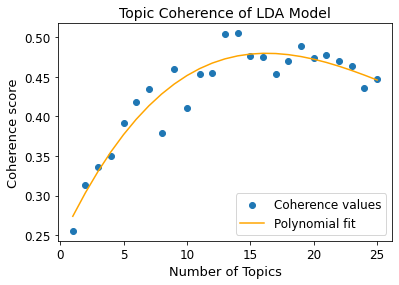

In [93]:

#limit=40; start=2; step=6;
x = range(1, 26, 1)
z = np.polyfit(x, values, 3)
y_pred = np.poly1d(z)
plt.scatter(x, values)
plt.plot(x, y_pred(x), color='orange')
plt.legend(['Coherence values', 'Polynomial fit'], loc='best', fontsize=12)
plt.xlabel("Number of Topics", fontsize=13)
plt.ylabel("Coherence score", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Topic Coherence of LDA Model", fontsize=14)
plt.savefig('coherence_model.png', facecolor='white')
plt.show()